In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feather
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from collections import defaultdict
from bitarray import bitarray
import networkx as nx
from scipy import signal

import riiideducation
tqdm_notebook.pandas(desc="progress: ")

pd.set_option("max_rows", 1000)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
DIR ="../input/riiid-test-answer-prediction/"
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")
train = pd.read_feather("../input/riid-train/train.feather")

# train
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before  seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

- content_type_id = 0なら、questions.csvと結合できる, content_type_id = 1なら、lectures.csvと結合できる

In [3]:
train.drop(["row_id", "user_answer", "content_type_id", "task_container_id", "prior_question_elapsed_time", "prior_question_had_explanation"], axis=1, inplace=True) #

In [4]:
train.head()

,timestamp,user_id,content_id,answered_correctly
0,0,115,5692,1
1,56943,115,5716,1
2,118363,115,128,1
3,131167,115,7860,1
4,137965,115,7922,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   timestamp           uint64
 1   user_id             uint32
 2   content_id          uint16
 3   answered_correctly  int8  
dtypes: int8(1), uint16(1), uint32(1), uint64(1)
memory usage: 1.4 GB


In [6]:
len(train.content_id.unique())

13782

In [7]:
train.head(10)

,timestamp,user_id,content_id,answered_correctly
0,0,115,5692,1
1,56943,115,5716,1
2,118363,115,128,1
3,131167,115,7860,1
4,137965,115,7922,1
5,157063,115,156,1
6,176092,115,51,1
7,194190,115,50,1
8,212463,115,7896,1
9,230983,115,7863,1


In [8]:
lec_index = list(train[train["answered_correctly"]==-1].index)

In [9]:
# accuracy before lecture
lec_before_index = [i-1 for i in lec_index] 
train[(train.index.isin(lec_before_index)) & (train["answered_correctly"]!=-1)]["answered_correctly"].mean()

0.4478886725540279

In [10]:
# overall accuracy mean
train[train["answered_correctly"] != -1]["answered_correctly"].mean()

0.6572355454194717

In [11]:
# accuracy after lecture
lec_after_index = [i+1 for i in lec_index] 
train[(train.index.isin(lec_after_index)) & (train["answered_correctly"]!=-1)]["answered_correctly"].mean()

0.7273451867124833

In [12]:
len(lec_after_index), len(lec_before_index)

(1959032, 1959032)

In [13]:
#tmp = train.iloc[:100,:].copy()
#first_day = np.datetime64('2015-01-01')
#time_values = tmp["timestamp"].values
#values = [first_day + np.timedelta64(time_values[0], 'D') for i in time_values]
#tmp["times"] = values
#tmp.groupby(['user_id'])[["times", "answered_correctly"]].apply(lambda x:x.ewm(halflife='1 days', times=pd.DatetimeIndex(x.times)).mean())

In [14]:
mod_train = train[train["answered_correctly"] != -1].reset_index(drop=True).copy()
mod_train["timestamp"] = (train['timestamp'] // 86400000) + 1 

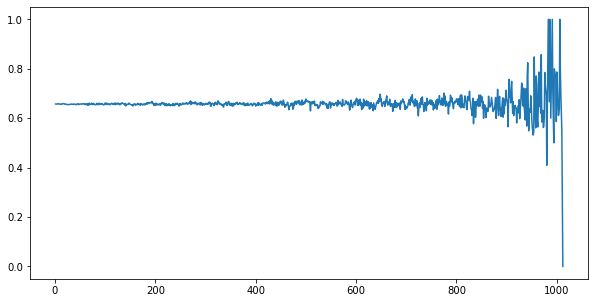

In [15]:
plt.figure(figsize=(10,5))
plt.plot(mod_train.groupby("timestamp")["answered_correctly"].agg(["mean"]))

<Figure size 1440x360 with 0 Axes>

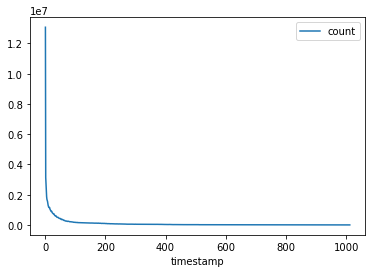

In [16]:
plt.figure(figsize=(20,5))
mod_train.groupby("timestamp")["answered_correctly"].agg(["count"]).plot()

In [17]:
#user_learning_time = train.drop_duplicates(["user_id","timestamp"])[["timestamp", "user_id"]].copy().reset_index(drop=True)
#user_learning_time["blank"] = user_learning_time.groupby("user_id")["timestamp"].diff()
#user_learning_time["blank"] -= 1
#user_learning_time["blank"] = user_learning_time["blank"].fillna(0)
#train = train.merge(user_learning_time, on=["user_id", "timestamp"])
#train.groupby("blank")["answered_correctly"].agg(["std"]).plot()
#train.groupby("blank")["answered_correctly"].agg(["mean"]).plot()
#train["mod_blank"] = train["blank"].apply(lambda x: 1 if x <=5 else 0)
#train.groupby("mod_blank")["answered_correctly"].agg(["mean"]).plot()

In [18]:
# from atma
#tmp = user_learning_time[user_learning_time.user_id==115].copy()
#tmp["cont_logdays"] = tmp.timestamp.diff().ne(1).cumsum()
#tmp["cont_logdays"] = tmp.groupby(['cont_logdays']).cumcount()+1

#user_learning_time = train.drop_duplicates(["user_id","timestamp"])[["timestamp", "user_id"]].copy().reset_index(drop=True)
#user_learning_time["new_blank"] = user_learning_time.groupby("user_id")["timestamp"].diff().ne(1).cumsum()
#user_learning_time["new_blank"] = user_learning_time.groupby(["user_id", 'new_blank']).cumcount()+1
#user_learning_time.head()

In [19]:
train.describe()

,timestamp,user_id,content_id,answered_correctly
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08
mean,7.703644e+09,1.076732e+09,5.219605e+03,6.251644e-01
std,1.159266e+10,6.197163e+08,3.866359e+03,5.225307e-01
min,0.000000e+00,1.150000e+02,0.000000e+00,-1.000000e+00
25%,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00
50%,2.674234e+09,1.071781e+09,5.026000e+03,1.000000e+00
75%,9.924551e+09,1.615742e+09,7.425000e+03,1.000000e+00
max,8.742577e+10,2.147483e+09,3.273600e+04,1.000000e+00


In [20]:
len(train.user_id.unique())

393656

In [21]:
#tmp = train[train.user_id==115].copy()
#tmp["task_container_id"] = tmp["task_container_id"].transform(lambda x: pd.factorize(x)[0]).astype('int16')
#tmp

In [22]:
train.content_id.value_counts().head()

6116    213605
6173    202106
4120    199372
175     195861
7876    190170
Name: content_id, dtype: int64

In [23]:
# null value in prior_question_had_explanation_only, but other variables include -1 as missing value in user_answer and answered_correctly
train.isnull().sum()

timestamp             0
user_id               0
content_id            0
answered_correctly    0
dtype: int64

In [24]:
# data num per user_id
#train.groupby("user_id").agg("max")["task_container_id"].plot(kind="hist")

In [25]:
#train["content_type_id"].sum() / train.shape[0] # lectureはわずか2%

In [26]:
#print(train.groupby("user_id")["content_type_id"].mean().max(), train.groupby("user_id")["content_type_id"].mean().min())
#print(train.groupby("user_id")["content_type_id"].mean().mean())

In [27]:
# had explanation in almost 90%
# train["prior_question_had_explanation"].value_counts(normalize=True)

In [28]:
#train = train.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
#train = train.loc[train['answered_correctly'] != -1].reset_index(drop=True)
#tmp = train.groupby('part').agg({'answered_correctly': ['mean']}).copy()
#tmp.columns = ['correct_rate']
#tmp

In [29]:
tmp = train.groupby("content_id")["answered_correctly"].mean().reset_index()
print(len(tmp[tmp.answered_correctly<0.2]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.2) & (tmp.answered_correctly<0.3)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.3) & (tmp.answered_correctly<0.4)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.4) & (tmp.answered_correctly<0.5)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.5) & (tmp.answered_correctly<0.6)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.5) & (tmp.answered_correctly<0.6)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.6) & (tmp.answered_correctly<0.7)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.7) & (tmp.answered_correctly<0.8)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.8) & (tmp.answered_correctly<0.9)]["content_id"]))
print(len(tmp[(tmp.answered_correctly>=0.9)]["content_id"]))

388
212
489
887
1569
1569
2497
3211
3112
1417


# lecture
- lectures.csv: metadata for the lectures watched by users as they progress in their education.
- lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
- part: top level category code for the lecture.
- tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- type_of: brief description of the core purpose of the lecture

In [30]:
lectures.shape

(418, 4)

In [31]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [32]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [33]:
lectures[lectures.type_of=="solving question"]["tag"].unique()

array([ 79, 156, 134,  80, 101,  74,  43, 109, 142, 140,   1,  26, 173,
         7,  64, 141, 124, 161,   4,  94,  70, 119, 177,  54,  50, 116,
        93, 136, 127,  53, 130,  13,  36,  62, 181, 164, 163,  85,  91,
         9,  28,  98, 159,  27, 149,  61, 166,  14, 113, 182,  55,  49,
       106,  47,  60, 179,  71,  82,  44,  25, 108,  96,   5, 152,  16,
        73, 178,  42,  40,   6, 157,  33,  51, 133,  48, 167,  68,  95,
        30, 174,  20,  66,  37,  45, 105, 151, 123, 114, 180,  89, 168,
        78, 111,  52,  34,   8, 184, 176,  72, 129, 128,  65, 125, 170,
       104,  69,   0])

In [34]:
lectures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [35]:
lectures.tag.min(), lectures.tag.max()

(0, 187)

In [36]:
lectures.tag.value_counts().head() # 一部タグに重複あり

136    7
116    6
134    6
27     6
161    6
Name: tag, dtype: int64

In [37]:
lectures.part.value_counts() # 一部タグに重複あり

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [38]:
lectures.type_of.value_counts() 

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [39]:
lectures.isnull().sum() # no missing value

lecture_id    0
tag           0
part          0
type_of       0
dtype: int64

In [40]:
len(lectures.lecture_id.unique())

418

In [41]:
len(set(lectures.lecture_id.unique()) & set(train.content_id.unique()))

417

In [42]:
# lecture id 28098 isn't included in training set
# set(lectures.lecture_id.unique()) - set(set(lectures.lecture_id.unique()) & set(train.content_id.unique()))

In [43]:
lectures[lectures.lecture_id==28098]

,lecture_id,tag,part,type_of
355,28098,166,6,solving question


In [44]:
len(lectures.tag.unique()) # overlap in tag

151

In [45]:
#lectures['type_of'] = lectures['type_of'].replace('solving question', 'solving_question')
#lectures = pd.get_dummies(lectures, columns=['part', 'type_of'])

In [46]:
#part_lectures_columns = [column for column in lectures.columns if column.startswith('part')]
#types_of_lectures_columns = [column for column in lectures.columns if column.startswith('type_of_')]

In [47]:
train_lec = train[train["answered_correctly"] == -1].reset_index(drop=True)
train_lec = train_lec.merge(lectures[["lecture_id", "tag"]], left_on="content_id", right_on="lecture_id", how="left")
train_lec.drop(["lecture_id"], axis=1, inplace=True)

In [48]:
train_lec.head()

,timestamp,user_id,content_id,answered_correctly,tag
0,653762,2746,6808,-1,129
1,10183847,5382,16736,-1,40
2,1424348597,5382,30207,-1,43
3,1425557777,5382,18545,-1,58
4,405813029,8623,10540,-1,99


In [49]:
tmp = train_lec.user_id.value_counts().reset_index(drop=False)
tmp.columns = ["user_id", "lec_num"]
tmp[tmp.lec_num>=200]

,user_id,lec_num
0,372519499,397
1,353540103,395
2,105239469,389
3,1066383521,386
4,2066672014,386
5,194669131,385
6,1109748920,379
7,499347415,377
8,1660941992,368
9,617553217,363


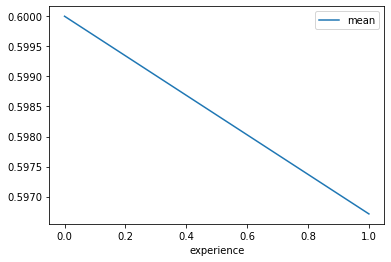

In [50]:
def calc(row):
    return len(row["tag"].intersection(row["tags"]))

user_id = 2042598372
sample_df = train[train.user_id==user_id].copy().reset_index(drop=True)

sample_df = sample_df.merge(lectures[["lecture_id", "tag"]], left_on="content_id", right_on="lecture_id", how="left")
sample_df = pd.merge(sample_df, questions[["question_id", "part", "tags"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
sample_df.drop(["question_id", "lecture_id"], axis=1, inplace=True)

sample_df["tag"] = sample_df["tag"].astype(str).replace("nan", "").cumsum()
sample_df["tag"] = sample_df["tag"].apply(lambda x: x.replace('.0', ', '))
sample_df["tag"] = sample_df["tag"].apply(lambda x: set(x))
sample_df["tags"] = sample_df["tags"].apply(lambda x: str(x).replace(' ', ', '))
sample_df["tags"] = sample_df["tags"].apply(lambda x: set(x))

sample_df = sample_df[sample_df["answered_correctly"] != -1].reset_index(drop=True)

sample_df["experience"] = sample_df.apply(calc, axis=1)
sample_df["experience"] = sample_df["experience"].apply(lambda x: 1 if x>=1 else 0)
sample_df.drop(["tag", "tags"], axis=1, inplace=True)
tmp = sample_df.groupby(["experience"])["answered_correctly"].agg(["mean"])
tmp.plot()

# questions
- questions.csv: metadata for the questions posed to users.
- question_id: foreign key for the train/test content_id column, when the content type is question (0).
- bundle_id: code for which questions are served together.
- correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
- part: the relevant section of the TOEIC test.
- tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [51]:
questions['tags'] = questions['tags'].apply(lambda ts: [int(x) for x in str(ts).split() if x != 'nan'])
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,"[51, 131, 162, 38]"
1,1,1,1,1,"[131, 36, 81]"
2,2,2,0,1,"[131, 101, 162, 92]"
3,3,3,0,1,"[131, 149, 162, 29]"
4,4,4,3,1,"[131, 5, 162, 38]"


In [52]:
questions.shape

(13523, 5)

In [53]:
questions['tags'].apply(lambda x: len(x)).max(), questions['tags'].apply(lambda x: len(x)).min() #max: 6, min: 1

(6, 0)

In [54]:
questions.correct_answer.value_counts(normalize=True) # 2 has the smallest ratio of correct answer

0    0.274791
3    0.262072
1    0.257191
2    0.205945
Name: correct_answer, dtype: float64

In [55]:
len(questions.question_id.unique())

13523

In [56]:
#questions[questions['tags'].isna()]
questions.iloc[10033][:]

question_id       10033
bundle_id         10033
correct_answer        2
part                  6
tags                 []
Name: 10033, dtype: object

In [57]:
questions.isnull().sum()

question_id       0
bundle_id         0
correct_answer    0
part              0
tags              0
dtype: int64

In [58]:
tag_to_questions = {}
for i, row in questions.iterrows():
    for t in row['tags']:
        if t not in tag_to_questions:
            tag_to_questions[t] = set()
        tag_to_questions[t].add(row['question_id'])
tags_df = pd.DataFrame([{'tag':t,'questions':qs}for t,qs in tag_to_questions.items()])
tags_df.head()

,tag,questions
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,..."
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ..."
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2..."
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,..."
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975..."


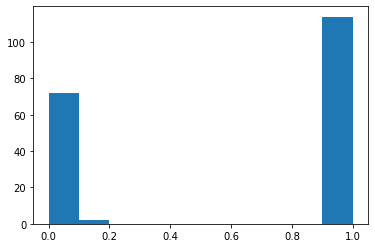

In [59]:
questions['multitag'] = questions['tags'].apply(lambda ts: len(ts)>1)

def calc_fract_multitagged(tag_row):
    tag_qs = questions[questions['question_id'].isin(tag_row['questions'])]
    return tag_qs[tag_qs['multitag']==True].size/tag_qs.size
tags_df['fraction_multitagged'] = tags_df.apply(calc_fract_multitagged, axis=1)
plt.hist(tags_df['fraction_multitagged'])
plt.show()

In [60]:
tags_df["questions_no"] = tags_df["questions"].apply(lambda x: len(x))

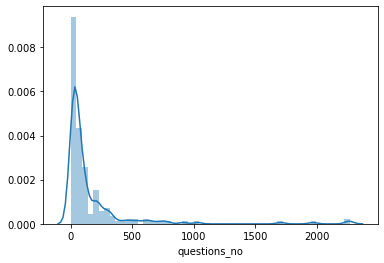

In [61]:
sns.distplot(tags_df.questions_no)

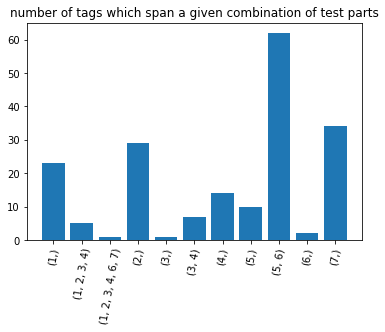

In [62]:
def calc_tag_parts(tag_row):
    tag_qs = questions[questions['question_id'].isin(tag_row['questions'])]
    return tuple(tag_qs['part'].unique())
tags_df['parts'] = tags_df.apply(calc_tag_parts, axis=1)

part_sizes = tags_df.groupby('parts').size()
plt.bar(range(len(part_sizes)), part_sizes)
plt.xticks(range(len(part_sizes)),part_sizes.index, rotation=80)
plt.title('number of tags which span a given combination of test parts')
plt.show()

In [63]:
tags_df.head(20)

,tag,questions,fraction_multitagged,questions_no,parts
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,...",1.0,71,"(1,)"
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.0,650,"(1,)"
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)"
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,...",1.0,2256,"(1, 2, 3, 4)"
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975...",1.0,35,"(1,)"
5,81,"{1, 5, 9, 11, 15, 19, 21, 25, 29, 31, 35, 37, ...",1.0,1969,"(1, 2, 3, 4)"
6,101,"{2, 12802, 12809, 138, 14, 10384, 147, 12822, ...",1.0,52,"(1,)"
7,92,"{2, 6, 8, 12, 16, 18, 22, 26, 28, 32, 34, 38, ...",1.0,2269,"(1, 2, 3, 4)"
8,149,"{128, 3, 10500, 5, 12806, 7946, 140, 7949, 128...",1.0,53,"(1,)"
9,29,"{3, 7, 13, 17, 23, 27, 43, 47, 53, 57, 73, 77,...",1.0,1707,"(1, 2, 3, 4)"


In [64]:
tags_df[tags_df.parts == (3,4)]

,tag,questions,fraction_multitagged,questions_no,parts
57,74,"{2048, 2051, 12291, 2058, 2060, 12300, 12303, ...",1.0,476,"(3, 4)"
58,136,"{12289, 2050, 2052, 12293, 2054, 2055, 2056, 2...",1.0,1033,"(3, 4)"
59,82,"{12290, 12292, 12299, 2062, 12305, 2067, 2068,...",1.0,527,"(3, 4)"
60,106,"{12288, 2049, 2069, 12312, 2075, 12315, 12318,...",1.0,457,"(3, 4)"
61,157,"{1537, 2053, 3077, 2568, 2059, 1548, 1549, 257...",1.0,206,"(3, 4)"
62,113,"{3074, 3076, 3079, 3082, 11813, 1575, 11816, 1...",1.0,156,"(3, 4)"
63,161,"{2561, 2564, 2567, 2570, 2573, 2577, 11795, 25...",1.0,146,"(3, 4)"


In [65]:
tags_df[tags_df.parts == (5,)]

,tag,questions,fraction_multitagged,questions_no,parts
84,66,"{5508, 5509, 5892, 4363, 5518, 4367, 4368, 616...",0.0,41,"(5,)"
85,108,"{9088, 3841, 5154, 5156, 9129, 3628, 8494, 517...",0.0,20,"(5,)"
90,15,"{8640, 8641, 8642, 8643, 8644, 6661, 5615, 561...",0.0,12,"(5,)"
102,57,"{3717, 9487, 9488, 9489, 9490, 3731, 9491, 949...",0.0,10,"(5,)"
116,112,"{9503, 9495, 9496, 9497, 9498, 9499, 9500, 950...",0.0,10,"(5,)"
132,78,"{4100, 4261, 6668, 4495, 4496, 5694}",0.0,6,"(5,)"
135,31,"{8645, 8646, 8647, 5192, 8648, 8649, 9259, 423...",0.0,10,"(5,)"
138,34,"{4258, 5698, 6087, 4821, 4664, 6394}",0.0,6,"(5,)"
142,124,"{8638, 6318, 8630, 8631, 8632, 8633, 8634, 863...",0.0,12,"(5,)"
147,167,"{6114, 6117, 6118, 9477, 9478, 9479, 9480, 948...",0.0,11,"(5,)"


In [66]:
tags_df[tags_df.fraction_multitagged == 0]

,tag,questions,fraction_multitagged,questions_no,parts
78,4,"{11520, 3969, 3970, 13440, 8198, 13324, 6414, ...",0.0,50,"(5, 6)"
79,166,"{11267, 11524, 8714, 11532, 13452, 11534, 3603...",0.0,60,"(5, 6)"
80,85,"{4992, 13320, 9100, 4114, 4755, 3609, 11420, 6...",0.0,24,"(5, 6)"
81,156,"{9094, 4999, 5001, 13450, 5004, 5006, 5007, 50...",0.0,43,"(5, 6)"
84,66,"{5508, 5509, 5892, 4363, 5518, 4367, 4368, 616...",0.0,41,"(5,)"
85,108,"{9088, 3841, 5154, 5156, 9129, 3628, 8494, 517...",0.0,20,"(5,)"
87,72,"{11266, 8453, 8455, 8456, 6028, 8461, 8465, 60...",0.0,72,"(5, 6)"
88,95,"{9283, 10211, 5702, 5704, 9289, 5614, 3632, 36...",0.0,17,"(5, 6)"
90,15,"{8640, 8641, 8642, 8643, 8644, 6661, 5615, 561...",0.0,12,"(5,)"
93,75,"{6669, 3864, 4519, 9776, 4791, 3639, 10175, 48...",0.0,23,"(5, 6)"


In [67]:
tags_df[tags_df['tag']==162]

,tag,questions,fraction_multitagged,questions_no,parts
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)"


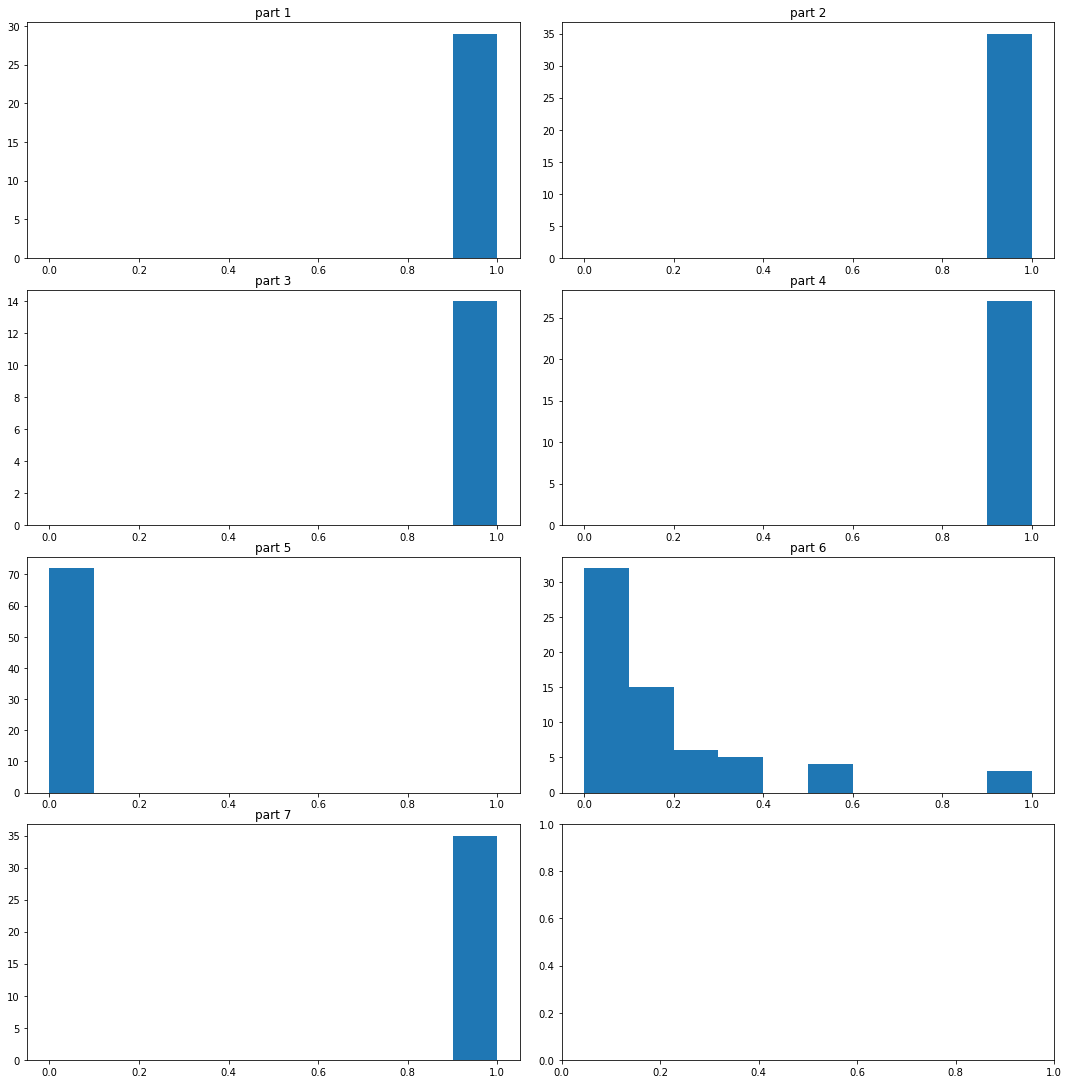

In [68]:
fig, axarr = plt.subplots(4, 2, figsize=(15, 15))
flat_axes_list = [item for sublist in axarr for item in sublist]

fig.tight_layout()

for part in range(1,8):
    # I want to specifically limit the logic to questions and tags in this part
    def calc_multitagged_in_part(tag_row):
        part_qs = questions[questions['part']==part]
        tag_qs = part_qs[part_qs['question_id'].isin(tag_row['questions'])]
        return tag_qs[tag_qs['multitag']==True].size/tag_qs.size
    part_multitagged = tags_df[tags_df['parts'].apply(lambda ps: part in ps)].apply(calc_multitagged_in_part, axis=1)
    ax = flat_axes_list[part-1]
    ax.set_title(f'part {part}')
    ax.hist(part_multitagged, bins=[x/10 for x in range(11)])

# combine lecture and question

In [69]:
tags_df['num_lectures'] = lectures.groupby('tag').count()['lecture_id']
tags_df['num_lectures'] = tags_df['num_lectures'].fillna(0).astype(int)

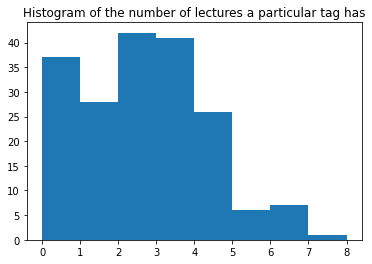

In [70]:
plt.hist(tags_df['num_lectures'], bins=range(9))
plt.title('Histogram of the number of lectures a particular tag has')
plt.show()

In [71]:
tags_df.head()

,tag,questions,fraction_multitagged,questions_no,parts,num_lectures
0,51,"{0, 12801, 12928, 10628, 11, 12, 12815, 12820,...",1.0,71,"(1,)",2
1,131,"{0, 1, 2, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, ...",1.0,650,"(1,)",4
2,162,"{0, 2, 3, 4, 5, 6, 7, 8, 7330, 17, 2065, 19, 2...",1.0,914,"(1, 2, 3, 4, 6, 7)",1
3,38,"{0, 4, 10, 14, 20, 24, 30, 33, 36, 39, 40, 44,...",1.0,2256,"(1, 2, 3, 4)",0
4,36,"{1, 10, 12811, 7957, 10523, 12835, 10660, 7975...",1.0,35,"(1,)",4


In [72]:
values = []
for i in tqdm(range(questions.shape[0])):
    if len(questions.iloc[i]["tags"]) > 0:
        values.append(sum([tags_df[tags_df.tag==j]["num_lectures"].values for j in questions.iloc[i]["tags"]])[0])
    else:
        values.append(0)

questions["num_of_lectures"] = values

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [73]:
content_acc_mean = mod_train.groupby("content_id")["answered_correctly"].agg(["mean"])
questions = questions.merge(content_acc_mean, left_on="question_id", right_on="content_id", how="left")

In [74]:
questions[["mean", "num_of_lectures"]].corr()

,mean,num_of_lectures
mean,1.000000,0.146969
num_of_lectures,0.146969,1.000000


# example_test
- row_id: (int64) ID code for the row.
- timestamp: (int64) the time between this user interaction and the first event completion from that user.
- user_id: (int32) ID code for the user.
- content_id: (int16) ID code for the user interaction
- content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
- task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
- user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
- answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
- prior_question_elapsed_time: (float32) The average time it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
- prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [75]:
example_test.head()

,row_id,group_num,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,prior_group_answers_correct,prior_group_responses
0,0,0,0,275030867,5729,0,0,NaN,NaN,[],[]
1,1,0,13309898705,554169193,12010,0,4427,19000.0,True,NaN,NaN
2,2,0,4213672059,1720860329,457,0,240,17000.0,True,NaN,NaN
3,3,0,62798072960,288641214,13262,0,266,23000.0,True,NaN,NaN
4,4,0,10585422061,1728340777,6119,0,162,72400.0,True,NaN,NaN


In [76]:
#%%timeit
#test1 = pd.merge(example_test, questions, left_on='content_id', right_on='question_id', how='left')

In [77]:
#%%timeit
#test2 = pd.merge(example_test, questions, left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)

# how to make features

In [78]:
#train = pd.merge(train, questions[["question_id", "part", "tags"]], left_on='content_id', right_on='question_id', how='left', right_index=True).reset_index(drop=True)
#train.drop("question_id", axis=1, inplace=True) #"tags"

In [79]:
#train = train[train["answered_correctly"] != -1].reset_index(drop=True)

In [80]:
#train.head()

In [81]:
# although tag information per user can be obtained, it builds features based on all activities.

#def join(df):
#    x = [str(e) for e in list(df)]
#    return " ".join(x)

#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import TruncatedSVD

#ids = ["tags"]
#concatenated_ = train[ids + ["user_id"]].copy().reset_index(drop=True)

#for id_ in ids:
#    print(id_)
#    docs = concatenated_.groupby("user_id")[id_].apply(join)
#    max_features = int(concatenated_[id_].nunique() * 0.8)
#    tv = TfidfVectorizer(max_features=max_features)
#    X = tv.fit_transform(docs)

#    n_components = 5
#    svd = TruncatedSVD(n_components=n_components)
#    X = svd.fit_transform(X)
#    df = pd.DataFrame(X, columns=[f"tfidf_{id_}_{i}" for i in range(n_components)])
#    df.index = docs.index

In [82]:
#def join(df):
#    x = [str(e) for e in list(df)]
#    return " ".join(x)

#ids = ["tags"]

#for id_ in ids:
#    print(id_)
#    docs = questions.groupby("question_id")[id_].apply(join)
#    max_features = int(questions[id_].nunique() * 0.8)
#    tv = TfidfVectorizer(max_features=max_features)
#    X = tv.fit_transform(docs)

#    n_components = 5
#    svd = TruncatedSVD(n_components=n_components)
#    X = svd.fit_transform(X)
#    df = pd.DataFrame(X, columns=[f"tfidf_{id_}_{i}" for i in range(n_components)])
#    df.index = docs.index

In [83]:
#train["prev1_content_id"] = train.groupby("user_id")["content_id"].shift(1)
#(train.iloc[:500]["prev1_content_id"].apply(lambda x: str(x)) + train.iloc[:500]["content_id"].apply(lambda x: str(x))).value_counts()

In [84]:
#train_users = list(train.user_id.unique())
#user_check = np.isin(example_test.user_id.values, train_users)
#example_test[user_check]

#user_check = np.isin(example_test.user_id.values, train_users)
#preds = np.zeros(len(example_test)) 
#pred_existing_users = model.predict(example_test.loc[user_check,features])
#pred_new_users = model2.predict(example_test.loc[~user_check,features])
#preds[user_check] = pred_existing_users
#preds[~user_check] = pred_new_users 

In [85]:
# how to make first_attempt
# takes about 10 minutes
#train["first_attempt"] = train[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                                                                    pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values

#for i in list(train.user_id.unique())[:10]:
#    tmp1 = np.isin(train[train.user_id==i]["row_id"].values, train[train.user_id==i].groupby("content_id").first()["row_id"].values)
#    tmp2 = np.isin(train[train.user_id==i]["row_id"], train[train.user_id==i].drop_duplicates("content_id")["row_id"])
#    print(i, np.all(tmp1 == tmp2))

#train[["row_id", "first_attempt"]].to_csv("content_first_attempt.csv", index=False)

In [86]:
#mod_train = train.iloc[:100,:].copy()
#mod_train["first_attempt"] = mod_train[["row_id", "user_id", "content_id"]].groupby("user_id").progress_apply(lambda x: 
#                                                                    pd.DataFrame(np.isin(x["row_id"].values, x.drop_duplicates("content_id")["row_id"].values))).values
#mod_train.head()

In [87]:
#%%time
#user_content_agg = train.groupby("user_id")["content_id"].unique().reset_index().set_index("user_id")

#value = []
#for j in user_content_agg.index:
#    a = bitarray(32737, endian='little')
#    a.setall(True)
#    for i in user_content_agg.loc[j][0]:
#        a[i] = 0
#    value.append(a)
    
#user_content_agg["content_exp"] = value

#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(int))

In [88]:
#user_content_dict = user_content_agg["content_exp"].to_dict()
#mod_first_attempt_values = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    if not user_id in user_content_dict.keys():
#        a = bitarray(32737, endian='little')
#        a.setall(True)   
#        user_content_dict[user_id] = a
#    mod_first_attempt_values.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [89]:
#def make_bitarray():
#    a = bitarray(32737, endian='little')
#    a.setall(True)   
#    return a
    
#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(make_bitarray))
#mod_first_attempt_values2 = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    mod_first_attempt_values2.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [90]:
#user_content_dict = user_content_agg["content_exp"].to_dict(defaultdict(int))
#first_attempt_values = []
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    if not user_id in user_content_agg.index:
#        a = bitarray(32737, endian='little')
#        a.setall(True)   
#        user_content_dict[user_id] = a
#    first_attempt_values.append(user_content_dict[user_id][content_id])
#    user_content_dict[user_id][content_id] = False 

In [91]:
#for i, (user_id, content_id) in enumerate(zip(example_test['user_id'].values, example_test['content_id'].values)):
#    print(i,train[(train["user_id"]==user_id) & (train["content_id"]==content_id)].shape, mod_first_attempt_values2[i])

In [92]:
#example_test["first_attempt"] = first_attempt_values

In [93]:
#from bitarray import bitarray
#sample_list = []
#for i in range(393656):
#    a = bitarray(13782, endian='little') # important to setup a fixed endianess.
#    a.setall(True)
#    sample_list.append(a)

In [94]:
#user_agg = train.groupby('user_id')['answered_correctly'].agg(['sum', 'count'])
#user_count_dict = user_agg['count'].astype('int16').to_dict(defaultdict(int))
#user_count_dict

In [95]:
#user_try = train.groupby('user_id')['row_id'].agg(["count"])
#user_try_dict = user_try['count'].astype('int16').to_dict(defaultdict(int))
#user_try_dict.head()

In [96]:
#user_count_dict == user_try_dict